# Final Exam Solution

## FINM 37400 - 2024

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# Instructions

## Please note the following:

Time
* You have 180 minutes to complete the exam.
* For every minute late you submit the exam, you will lose one point.

Submission
* You will upload your solution to the Final Exam assignment on Canvas.
* Your submission should be readable, (the graders can understand your answers,) and it should include all code used in your analysis in a file format that the code can be executed. (ie. .ipynb preferred, .pdf is unacceptable.)

Rules
* The exam is open-material, closed-communication.
* You do not need to cite material from the course github repo--you are welcome to use the code posted there without citation, (only for this exam.)

Advice
* If you find any question to be unclear, state your interpretation and proceed. We will only answer questions of interpretation if there is a typo, error, etc.
* The exam will be graded for partial credit.

## Data

**All data files are found in the class github repo, in the `data` folder.**

This exam makes use of the following data files:

#### Section 2
* New file: `select_maturities_2017-02-07.xlsx`

#### Section 3
* Familiar file: `famabliss_strips_2023-12-29.xlsx`

## Scoring

| Problem | Points |
|---------|--------|
| 1       | 25     |
| 2       | 45     |
| 3       | 60     |
| 4       | 35     |
| **Total**   | **165**|

***

# 1. Long-Short Trades

Consider the following market data as of `Dec 29, 2023`.

The table below shows two Treasury securities, a T-note and a T-bond. They mature on the same date.

In [39]:
import pandas as pd
summary = pd.DataFrame(index=[],columns = [207391,204095],dtype=float)
summary.loc['issue date'] = ['2019-08-15','1999-08-15']
summary.loc['maturity date'] = ['2029-08-15','2029-08-15']
summary.loc['coupon rate'] = [.01625, .06125]
summary.loc['clean price'] = [89.03125,111.0391]
summary.loc['accrued interest'] = [.6005, 2.2636]
summary.loc['ytm'] = [.037677, .038784]
summary.loc['duration'] = [5.3494,4.7967]
summary

,207391,204095
issue date,2019-08-15,1999-08-15
maturity date,2029-08-15,2029-08-15
coupon rate,0.01625,0.06125
clean price,89.03125,111.0391
accrued interest,0.6005,2.2636
ytm,0.037677,0.038784
duration,5.3494,4.7967


### 1.1. (5pts)

Explain the long-short trade you would enter based on the market data above, without any further calculation. 

### 1.2. (5pts)

Size your trade.
* Suppose the long side is set to $100 million market value. 
* Size the short to be duration-neutral.

Report the market value in the short-side of the trade and the number of long and short contracts.

### 1.3. (5pts)

What are the risks of this trade in the short-term and in the long-term?

### 1.4. (5pts)

Use **modified duration**--not the Macauley duration reported above--to estimate how much pnl will be earned if the securities converge (symmetrically).

### 1.5. (5pts)

For which of these securities will the duration approximation be less accurate? Explain.

***

# <span style="color:red">Solution 1</span>

In [40]:
import numpy as np
import datetime
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import minimize

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *
from tradebondpair import *

## <span style="color:red">1.1</span>

We should go **long** the **higher** YTM, and **short** the **lower** YTM.

Note that this is **not** the same as going long the bond with lower price and shorting the bond with higher price. Given the difference in coupons, the higher price is not indicative of the 30-year being a worse deal. Rather, its higher YTM shows it is more attractive.

Optionally, one could mention that the long-short trade might be sized to 
* be duration neutral to reduce sensitivity to changes in interest rates. 
* be dollar neutral to be self-funded with very low net duration.

## <span style="color:red">1.2</span>

Use the formula seen in class:

$$n_j = -n_i\frac{D_{\$,i}}{D_{\$,j}}$$

Use dollar duration in this formula, based on the **dirty** price.

#### Grading note
Partial credit for using 
* duration instead of dollar duration
* calculating dollar duration via clean price instead of dirty price.

In [41]:
SIZELONG = 100e6

summary.loc['dirty price'] = summary.loc['clean price'] + summary.loc['accrued interest']
summary.loc['dollar duration'] = summary.loc['duration'] * summary.loc['dirty price']

keyLong = summary.loc['ytm'].astype('float64').idxmax()
keyShort = summary.loc['ytm'].astype('float64').idxmin()

summary.loc['contracts',keyLong] = SIZELONG / summary.loc['dirty price',keyLong]
summary.loc['contracts',keyShort] = -summary.loc['contracts',keyLong] * (summary.loc['dollar duration',keyLong]/summary.loc['dollar duration',keyShort])
summary.loc['market value'] = summary.loc['contracts'] * summary.loc['dirty price']

out = summary.loc[['dirty price', 'dollar duration', 'contracts','market value']].T
out.style.format('{:,.2f}')

,dirty price,dollar duration,contracts,market value
207391,89.63,479.48,"-1,000,404.43","-89,668,000.15"
204095,113.30,543.48,"882,591.50","100,000,000.00"


## <span style="color:red">1.3</span>

In the **long-term**, there is no market risk.
* If held to maturity, guaranteed to profit according to difference in YTM.

In the **short-term**, there is market risk.
* The YTM could diverge further, causing a short-term loss. 
* This could pressure the trader to unwind due to financing and short-term losses.

## <span style="color:red">1.4</span>

The table below shows the modified duration and approximated percentage change in value of each side of the trade.

* The final row shows the pnl approximation based on the trade size from `1.2` above.
* Note that the shift in the YTM approximated is half the total YTM spread on each side.

#### Formula

From `W.2.`, modified duration is (for semiannually compounding)

$$D\frac{1}{1+y/2}$$

In [42]:
COMPOUNDING = 2

pnl_approx = summary.loc[['ytm','duration']].copy()

ytm_convergence = pnl_approx.loc['ytm',keyLong] - pnl_approx.loc['ytm',keyShort]
pnl_approx.loc['ytm convergence',keyLong] = -ytm_convergence/2
pnl_approx.loc['ytm convergence',keyShort] = ytm_convergence/2

pnl_approx.loc['modified duration'] = pnl_approx.loc['duration'] / (1+pnl_approx.loc['ytm']/COMPOUNDING)
pnl_approx.loc['pct change value'] = -pnl_approx.loc['modified duration'] * pnl_approx.loc['ytm convergence']

pnl_approx.loc['pnl'] = pnl_approx.loc['pct change value'] * out['market value']
pnl_approx = pnl_approx.T

pnl_approx.loc['net','pnl'] = pnl_approx['pnl'].sum()

pnl_approx.style.format({'ytm':'{:.2%}','pct change value':'{:.2%}','pnl':'${:,.2f}'})

,ytm,duration,ytm convergence,modified duration,pct change value,pnl
207391,3.77%,5.349400,0.000553,5.250489,-0.29%,"$260,588.25"
204095,3.88%,4.796700,-0.000553,4.705452,0.26%,"$260,446.76"
net,nan%,nan,nan,nan,nan%,"$521,035.01"


## <span style="color:red">1.5</span>

The lower coupon security will have higher convexity and thus **less accurate** approximation of pnl via duration.

In [43]:
if summary.loc['coupon rate'].idxmin()==keyLong:
    idPos = 'LONG'
else:
    idPos = 'SHORT'
    
display(f'The {idPos} position will have a less accurate duration approximation due to higher convexity.')

'The SHORT position will have a less accurate duration approximation due to higher convexity.'

***

# 2. Extracting Curves

Use the selected treasury quotes in the file, `select_maturities_2017-02-07.xlsx`.

* Market quots are provided for treasury securities expiring approximately every six months over the next ten years.
* You are welcome to assume that they mature at exaclty six-year increments or to use the exact dates.
* Consider the `price` column to represent the dirty mid price. Use it as quoted, without further adjustment.

### 2.1 (10pts)

Bootstrap the spot curve. Report it in both...
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

### 2.2 (10pts)

Calculate the Nelson-Siegel curve using the parameters below. (Not the NS-extended; just four parameters.)

Report both
* discount factors, $Z$
* (semiannually compounded) discount rates, $r$

In [44]:
params = pd.DataFrame(columns=['Nelson-Siegel parameters'],index=['theta0', 'theta1','theta2','lambda1'],data=[0.031627,-0.025166, -0.020701, 1.514887]).T
display(params)

,theta0,theta1,theta2,lambda1
Nelson-Siegel parameters,0.031627,-0.025166,-0.020701,1.514887


### 2.3 (5pts)

Plot...
* bootstrapped spot rates
* Nelson-Siegel spot rates
* provided ytm

### 2.4 (10pts)

Which of the two spot rate curves (bootstrapped or Nelson-Siegel) would be better for...
* pricing the provided sample?
* building spot rates out to 30 years?
* calculating forward rates?

For each of these three questions, be **specific** in your answer.

### 2.5 (5pts)

Consider the bootstrapped curve and its associated forward curve. (No need to calculate the forward curve.)

Conceptually, do you expect it is higher or lower than the spot-rate curve at
* $T=1$
* $T=10$

Explain.

### 2.6 (5pts)

Use the bootstrapped spot curve to calculate the forward rate for $T_1=3\to T_2=3.5$.

***

# <span style="color:red">Solution 2</span>

In [45]:
filepath = '../data/select_maturities_2017-02-07.xlsx'
quotes = pd.read_excel(filepath).set_index('kytreasno')
quotes['price'] = (quotes['bid'] + quotes['ask'])/2 + quotes['accrint']
quotes

,date,issue date,maturity date,ttm,bid,ask,accrint,ytm,duration,outstanding,cpn rate,instrument,price
kytreasno,,,,,,,,,,,,,
206525,2017-02-07,2012-08-31,2017-08-31,0.561259,99.945312,99.984375,0.276243,0.006830,0.559690,60995,0.625,2,100.241087
206589,2017-02-07,2013-02-28,2018-02-28,1.056810,99.835938,99.875000,0.331492,0.008865,1.051226,69708,0.750,2,100.186960
207005,2017-02-07,2016-08-31,2018-08-31,1.560575,99.531250,99.570312,0.331492,0.010370,1.549334,27778,0.750,2,99.882273
206708,2017-02-07,2014-02-28,2019-02-28,2.056126,100.570312,100.617188,0.662983,0.012044,2.019424,35097,1.500,2,101.256733
206767,2017-02-07,2014-08-31,2019-08-31,2.559890,100.710938,100.734375,0.718232,0.013312,2.500337,35002,1.625,2,101.440888
206823,2017-02-07,2015-02-28,2020-02-29,3.058179,99.718750,99.765625,0.607735,0.014560,2.987188,34999,1.375,2,100.349922
206887,2017-02-07,2015-08-31,2020-08-31,3.561944,99.218750,99.265625,0.607735,0.015868,3.466990,35000,1.375,2,99.849922
206947,2017-02-07,2016-02-29,2021-02-28,4.057495,97.664062,97.710938,0.497238,0.017102,3.956565,45395,1.125,2,98.184738
207007,2017-02-07,2016-08-31,2021-08-31,4.561259,97.031250,97.078125,0.497238,0.017916,4.434572,36326,1.125,2,97.551925


## <span style="color:red">2.1</span>

In [46]:
import numpy as np
from scipy.optimize import fsolve

Consider the bootstrap function used in `Homework 4`:

In [47]:
def bootstrap_spot_rates(df):
    """
    Bootstraps spot rates from a dataframe of bond information.
    
    :param df: Pandas DataFrame with columns 'price', 'cpn rate', and 'ttm'
    :return: Pandas Series of spot rates indexed by TTM
    """
    # Ensure the DataFrame is sorted by TTM
    df = df.sort_values(by='ttm')
    
    # Initialize a dictionary to store spot rates
    spot_rates = {}

    # Iterate over each bond
    for index, row in df.iterrows():
        ttm, coupon_rate, price = row['ttm'], row['cpn rate'], row['price']
        cash_flows = [coupon_rate / 2] * round(ttm * 2)  # Semi-annual coupons
        cash_flows[-1] += 100  # Add the face value to the last cash flow

        # Function to calculate the present value of cash flows
        def pv_of_cash_flows(spot_rate):
            pv = 0
            for t in range(1, len(cash_flows) + 1):
                if t/2 in spot_rates:
                    rate = spot_rates[t/2]
                else:
                    rate = spot_rate
                pv += cash_flows[t - 1] / ((1 + rate / 2) ** t)
            return pv

        # Solve for the spot rate that sets the present value of cash flows equal to the bond price
        spot_rate_guess = (cash_flows[-1] / price) ** (1/(ttm*2)) - 1
        spot_rate = fsolve(lambda r: pv_of_cash_flows(r) - price, x0=spot_rate_guess)[0]

        # Store the calculated spot rate
        spot_rates[ttm] = spot_rate

    return pd.Series(spot_rates)

In [48]:
COMPOUNDING = 2

spot = pd.DataFrame(bootstrap_spot_rates(quotes))
spot.columns = ['rate']
spot['discount factor'] = intrate_to_discount(spot['rate'],spot.index,n_compound=COMPOUNDING)

In [49]:
spot

,rate,discount factor
0.561259,0.001425,0.999201
1.056810,0.005623,0.994084
1.560575,0.008291,0.987170
2.056126,0.008648,0.982413
2.559890,0.010396,0.973805
3.058179,0.012558,0.962440
3.561944,0.014191,0.950878
4.057495,0.015953,0.937564
4.561259,0.016923,0.926015
5.056810,0.017189,0.917090


## <span style="color:red">2.2</span>

In [50]:
ns = pd.DataFrame(nelson_siegel(params.iloc[0,:].values,spot.index),index=spot.index,columns=['rate'])
ns['discount factor'] = intrate_to_discount(ns['rate'],ns.index,n_compound=COMPOUNDING)
ns

,rate,discount factor
0.561259,0.007590,0.995757
1.056810,0.008911,0.990648
1.560575,0.010385,0.983965
2.056126,0.011858,0.975983
2.559890,0.013314,0.966602
3.058179,0.014674,0.956273
3.561944,0.015950,0.944985
4.057495,0.017100,0.933245
4.561259,0.018163,0.920836
5.056810,0.019109,0.908306


## <span style="color:red">2.3</span>

In [51]:
tab = spot[['rate']].copy()
tab.columns = ['bootstrap']
tab['nelson-siegel'] = ns[['rate']].copy()

ax = tab.plot();
(quotes[['ttm','ytm']].set_index('ttm')).plot(ax=ax,linestyle='',marker='*',color='k');

## <span style="color:red">2.4</span>

* Bootstrap will price perfectly in-sample.
* Nelson-Siegel can easily extend to arbitrary maturities, whereas the bootstrap will fail when TTM extends past available market data (~11 years).
* Nelson-Siegel will generate smoother forward rates

## <span style="color:red">2.5</span>

* The forward curve is above the spot curve at $T=1$.
* The forward curve is below the spot curve at $T=10$.

This can be inferred from the relationship seen in `W.4.` The spot curve increases if and only if the forward is above the spot. And the spot is decreasing if and only if the forward is below the spot.

## <span style="color:red">2.6</span>

From `Solution 4`.

No need to show the entire curve--just report $T=3$ to $T=3.5$.

Nearly full credit for reporting an adjacent forward rate.

In [52]:
forward = pd.DataFrame(spot['discount factor']/spot['discount factor'].shift(),index=spot.index, columns=['discount factor'])
forward['discount factor'].iloc[0] = spot['discount factor'].iloc[0]
forward['rate'] = -np.log(forward['discount factor']) / forward.index.to_series().diff().mean()

In [53]:
T2 = 3.5

# get index closest to value given Time-to-maturity are not exactly half years
idx = forward.index[abs(forward.index - T2).argmin()]

fwd_reported = forward.loc[idx,'rate']
display(f'The forward rate to {T2} years is {fwd_reported:.2%}')

'The forward rate to 3.5 years is 2.43%'

In [54]:
forward[['rate']].style.format('{:.2%}')

,rate
0.561259,0.16%
1.056810,1.03%
1.560575,1.40%
2.056126,0.97%
2.559890,1.77%
3.058179,2.36%
3.561944,2.43%
4.057495,2.83%
4.561259,2.49%
5.056810,1.95%


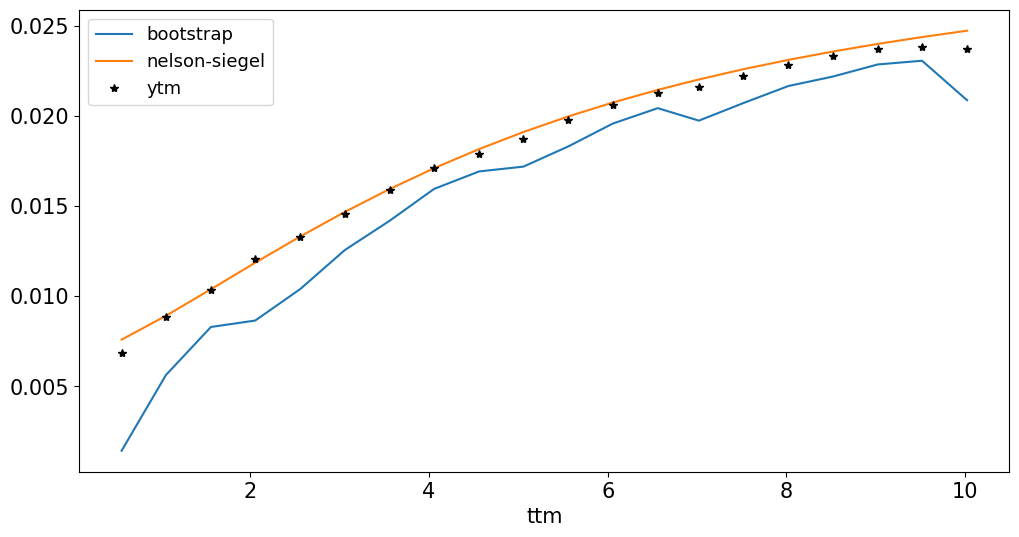

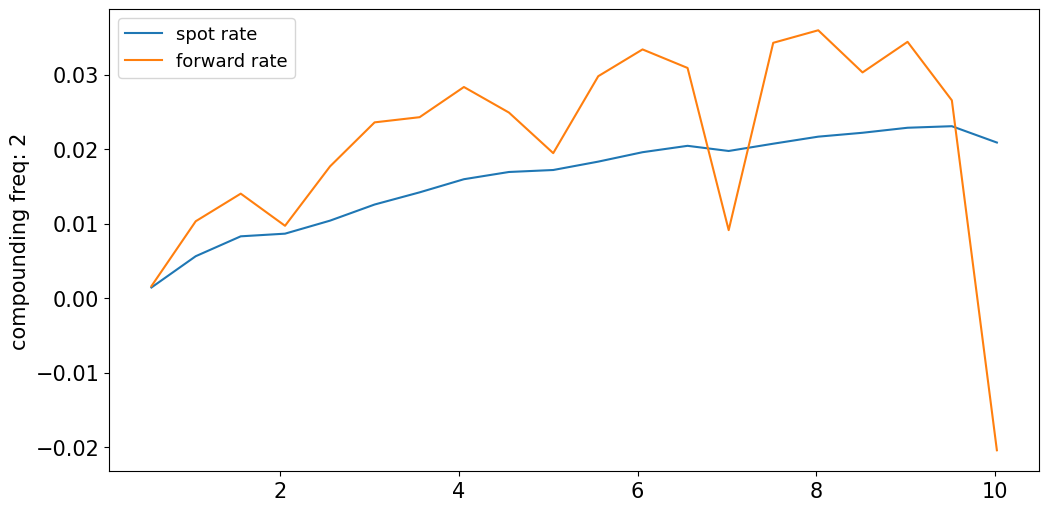

In [55]:
fig, ax = plt.subplots()
spot['rate'].plot(ax=ax)
forward['rate'].plot(ax=ax)
plt.legend(['spot rate','forward rate'])
plt.ylabel(f'compounding freq: {COMPOUNDING}')
plt.show()

***

# 3. Trading the Yield Curve



Use the file, `famabliss_strips_2023-12-29.xlsx` for the following problem.

* The file provides prices for **strips** which are zero-coupon bonds. 
* Assume face value of 100.
* Because these prices are on zero-coupon bonds, they can be interpreted as discount factors, $Z$, directly.

Note that you will make use of only a few rows of the data set.

### 1. (10pts)

Set up a trade as of `2010-01-29` to 
* go long 100 million (market value) of the 5-year.
* short the 2-year strips in a quantity that is duration hedged.

List the positions you hold long and short. 
* Assume you are financing the positions directly; no worries about haircuts. 
* Assume there are no market frictions, so you can short securities and immediately receive their market value. 
* (No need to worry about borrowing costs for the short.)

### 2. (5pts)
As of `2011-01-31`, assess the pnl on the long, short, and net trade.

### 3. (10pts)
On `2011-01-31`, roll over the trade.
* close out the short positions
* enter new short positions in 2-year strips that are a duration hedge against your (continuing) long positions.

List the details of your short and long positions in terms of market value and face value of each side of the trade.

### 4. (5pts)
On `2012-01-31`, close out the trade.

Report...
* pnl for the long, short, and net of the trade.

### 5. (5pts)
How did this trade do compared to a long-only trade in 5-year notes? Explain.

### 6. (5pts)

Notwithstanding the duration hedge, why was the trade still sensitive to changing levels of the spot rate curve?

Be specific in your answer, and consider which quantitative metric would support your answer.

### 7. (5pts)

Does this trade rely on the Expectations Hypothesis being true or false? How about this type of trade in general?

### 8. (5pts)

As of `2012-01-31`, is the market environment favorable to this type of long-short trade?

Be specific.

### 9. (5pts)

As of `2010-01-29`, what is the continuously compounded forward rate from $T_1=2\to T_2=4$?

### 10. (5pts)

As of `2012-01-31`, is the two-year continuously-compoounded spot rate, $r(0,2)$ higher or lower than the forward rate calculated above for `2010-01-29`?

Is this surprising?

***

# <span style="color:red">Solution 3</span>

Load the data, and keep just a subset.

In [56]:
filepath = '../data/famabliss_strips_2023-12-29.xlsx'
prices = pd.read_excel(filepath, sheet_name='prices')
prices.set_index('date',inplace=True)
prices.columns = prices.columns.astype(int)

# organize subset
px = prices['2010':'2012'].iloc[::12]
# face value
FACE = 100

# log spot rates
spots = -np.log(px/FACE)/px.columns

## <span style="color:red">3.1</span>

Note that for zero-coupon bonds (strips), the duration equals the maturity.

In [57]:
LONGSIZE = 100e6
LONGMAT = 5
SHORTMAT = 2

duration_ratio = LONGMAT/SHORTMAT
SHORTSIZE = -LONGSIZE * duration_ratio

The positions are as follows, where each contract corresponds to face value of 100.

In [58]:
positions = pd.DataFrame(index=px.index, columns=px.columns, dtype=float, data=0)
positions[LONGMAT].iloc[0] = LONGSIZE/px[LONGMAT].iloc[0]
positions[SHORTMAT].iloc[0] = SHORTSIZE/px[SHORTMAT].iloc[0]
positions.iloc[[0],:].style.format('{:,.2f}').format_index('{:%Y-%m-%d}')

positions.iloc[[0],:].style.format('{:,.2f}').format_index('{:%Y-%m-%d}')

,1,2,3,4,5
date,,,,,
2010-01-29,0.00,"-2,539,847.73",0.00,0.00,"1,124,880.49"


The market values of the positions are below.

In [59]:
mktvals = positions.copy()
mktvals *= px
mktvals.insert(0,'cash',0)
mktvals.loc['2010','cash'] = -SHORTSIZE - LONGSIZE
mktvals.iloc[[0],:].style.format('{:,.2f}').format_index('{:%Y-%m-%d}')

,cash,1,2,3,4,5
date,,,,,,
2010-01-29,"150,000,000.00",0.00,"-250,000,000.00",0.00,0.00,"100,000,000.00"


## <span style="color:red">3.2</span>

In [60]:
px_new = positions.iloc[[0],1:].values * px.iloc[[1],0:-1].values
px_old = mktvals.iloc[0,2:].values

mktvals.iloc[[1],1:-1] = px_new
mktvals.iloc[[1],0] = mktvals.iloc[[0],0] 

The net pnl on the trade...

In [61]:
tab = pd.DataFrame([(px_new - px_old)[0,[0,3]]],columns=['shorts','longs'],index=['pnl for 2011-01-31']).T
tab.loc['net'] = tab.sum()
tab.style.format('${:,.2f}')

,pnl for 2011-01-31
shorts,"$-3,195,323.56"
longs,"$6,179,199.31"
net,"$2,983,875.75"


## <span style="color:red">3.3</span>

### Market values

See below for the market values of the positions.

**No need** to show what is happening to cash over this time, given that the problem says to ignore financing.

#### Technical point
One might model the excess cash as being invested in (risk-free) one-year bonds each period. 

This was not required in the problem.

In [62]:
longmat = 4
shortmat = 2
shortvals = - mktvals[4].iloc[1] * longmat/shortmat
mktvals.iloc[1,2] = shortvals
mktvals.iloc[1,1] -= shortvals
mktvals.iloc[1,0] += mktvals.iloc[1,1]
mktvals.iloc[1,1] = 0

mktvals.iloc[0:-1,:].style.format('${:,.2f}').format_index('{:%Y-%m-%d}')

,cash,1,2,3,4,5
date,,,,,,
2010-01-29,"$150,000,000.00",$0.00,"$-250,000,000.00",$0.00,$0.00,"$100,000,000.00"
2011-01-31,"$109,163,075.06",$0.00,"$-212,358,398.62",$0.00,"$106,179,199.31",$0.00


### Face value (contracts)

Below, see the number of contracts (each representing 100 face value).

In [63]:
positions.iloc[1,:] = mktvals.iloc[1,1:] / px.iloc[1,1:]
positions.iloc[1,0] = 0
positions.iloc[0:-1,:].style.format('{:,.2f}').format_index('{:%Y-%m-%d}')

,1,2,3,4,5
date,,,,,
2010-01-29,0.00,"-2,539,847.73",0.00,0.00,"1,124,880.49"
2011-01-31,0.00,"-2,146,606.59",0.00,"1,124,880.49",0.00


## <span style="color:red">3.4</span>

In [64]:
px_new = positions.iloc[[1],1:].values * px.iloc[[2],0:-1].values
px_old = mktvals.iloc[1,2:].values

mktvals.iloc[[2],1:-1] = px_new
mktvals.iloc[[2],0] = mktvals.iloc[[1],0] 

See below for the pnl on the longs, shorts, and net position.

In [65]:
tab['pnl for 2012-01-31'] = np.nan
tab['pnl for 2012-01-31'].iloc[:-1] = (px_new - px_old)[0,[0,2]]
tab.loc['net','pnl for 2012-01-31'] = tab['pnl for 2012-01-31'].iloc[:-1].sum()
tab['cumulative pnl'] = tab.sum(axis=1)
tab.style.format('${:,.2f}')

,pnl for 2011-01-31,pnl for 2012-01-31,cumulative pnl
shorts,"$-3,195,323.56","$-1,974,658.08","$-5,169,981.64"
longs,"$6,179,199.31","$5,284,231.55","$11,463,430.86"
net,"$2,983,875.75","$3,309,573.47","$6,293,449.22"


**Not required**

The chart below shows how the market value is changing over time in the positions.

Note that the sum of each row gives the cumulative pnl, and it matches the pnl table above.

In [66]:
mktvals.insert(0,'cumulative pnl',0)
mktvals['cumulative pnl'] = mktvals.sum(axis=1)
mktvals.style.format('${:,.2f}').format_index('{:%Y-%m-%d}')

,cumulative pnl,cash,1,2,3,4,5
date,,,,,,,
2010-01-29,$0.00,"$150,000,000.00",$0.00,"$-250,000,000.00",$0.00,$0.00,"$100,000,000.00"
2011-01-31,"$2,983,875.75","$109,163,075.06",$0.00,"$-212,358,398.62",$0.00,"$106,179,199.31",$0.00
2012-01-31,"$6,293,449.22","$109,163,075.06","$-214,333,056.70",$0.00,"$111,463,430.86",$0.00,$0.00


## <span style="color:red">3.5</span>

The long-only trade in the 5-year bond would deliver the following pnl.

In [67]:
pnl_buyhold = positions.iloc[0,4] * (px.iloc[2,2] - px.iloc[0,4])
tab_cumpnl = pd.DataFrame([pnl_buyhold],index=['long-only (unhedged)'],columns=['cumulative pnl (2010-2012)'])
tab_cumpnl.loc['long-short (duration hedged)'] = tab.loc['net','cumulative pnl']
tab_cumpnl.style.format('${:,.2f}')

,cumulative pnl (2010-2012)
long-only (unhedged),"$11,463,430.86"
long-short (duration hedged),"$6,293,449.22"


The long-only trade has nearly 2x the pnl. Throughout the two years, rates are going down. Thus, the long-only trade benefits from changes in levels of interest rates, whereas the duration-hedged long-short trade loses on the shorts, benefitting less from overall rate changes.

## <span style="color:red">3.6</span>

The duration-hedged trade is still sensitive to interest rate changes for two reasons:
* The positions have convexity. The long-short trade still ahs positive convexity.
* The changes to interest rates are not parallel shifts of the spot curve, which means duration is not perfectly hedgeing even the linear effects.

## <span style="color:red">3.7</span>

No, this trade does not depend on the EH. The EH says what will happen on **average** not in a given trade.

In general, these types of trades rely on the EH being false, as they say that **on average** there is positive pnl in holding the higher yield security, (in this case, the 5-year bond.)

## <span style="color:red">3.8</span>

Based on our study of the EH, this environment is not favorable to this trade as of 2012.

The term structure is flat, as seen by the spot rates. We saw evidence that this type of long-short trade tends to do better when the term structure has a strong upward slope.

In [68]:
spots.loc['2012'].style.format('{:.2%}').format_index('{:%Y-%m-%d}')

,1,2,3,4,5
date,,,,,
2012-01-31,0.15%,0.22%,0.31%,0.49%,0.73%


## <span style="color:red">3.9</span>

The two-year forward rates are below, where the column label denotes $T_2$. That is, column `4` denotes the forward rate as of that date between $T_1=2\rightarrow T_2=4$.

Note that the values in column `2` are equivalent to two-year spot rates, as they are forwards from $T_1=0$ to $T_2=2$.

#### Note
Not required to show this whole table, but rather to just report the single value below.

In [69]:
F = px[[3,4,5]] / px[[1,2,3]].values
f = -np.log(F)
f.insert(0,2,spots[2])
f.style.format('{:.2%}').format_index('{:%Y-%m-%d}')

,2,3,4,5
date,,,,
2010-01-29,0.79%,3.69%,5.79%,7.77%
2011-01-31,0.54%,2.60%,4.69%,6.94%
2012-01-31,0.22%,0.76%,1.51%,2.71%


In [70]:
frate = f.loc['2010',4].values[0]
display(f'The forward rate as of 2010 for 2 to 4 is {frate:.2%}.')

'The forward rate as of 2010 for 2 to 4 is 5.79%.'

## <span style="color:red">3.10</span>

From the table above, we see the 2-year **forward** rate from 2 to 4 in 2010 is substantially higher than the 2-year **spot** rate in 2012.

This is not a surprise. Had the rate in 2012 been as high as the 2010 spot indicated, the trades above would not have been as profitable. The trades benefited from rates being lower in 2012 than the forwards would have predicted in 2010.

***

# 4. The Swap-Spread

Consider the market data below. 
* It refers to **20-year** T-bonds and swaps.
* Assume the T-bond has exactly 20-years to maturity, with a coupon that exactly matches the YTM below.

In [71]:
SWAPRATE = [.027639,.039895]
YTM = [.031480, .046670]

summary = pd.DataFrame(index=['YTM','swap rate'],columns = ['Nov 2018','Nov 2023'],dtype=float)
summary.loc['YTM'] = YTM
summary.loc['swap rate'] = SWAPRATE
summary.style.format('{:.4%}')

,Nov 2018,Nov 2023
YTM,3.1480%,4.6670%
swap rate,2.7639%,3.9895%


### 4.1. (5pts)

Consider `Nov 2018`. Suppose you enter into a swap-spread trade.
* You go long \$100 million **market value** of 20-year T-bonds.
* You simultaneously enter a 20-year swap, paying-fixed, with notional of \$100 million.


Report the 
* price of the T-bond in Nov 2018.
* amount of T-bonds purchased, (each face value of 100).

### 4.2. (5pts)

Report the first cashflow of the trade, in May 2019.

For simplicity, 
* assume the swap pays semiannually, at the same date the T-bond pays coupons.
* the repo rate involved in the trade cancels out with the floating rate of the swap.
* the repo term is semiannually, corresponding to the coupon and swap dates.
* there are not any margin calls or distributions in the discussion below.

If the haircut is 4\% to repo the T-bonds, then what is the May 2019 cashflow as a percentage of the equity capital in the position?

### 4.3. (5pts)

Report the risk of the trade.
* Duration and dollar duration for the T-bond
* Duration and dollar duration for the swap

Note that you are reporting the usual, Macauley, duration--not the modified duration. 

For each of these duration calculations, use only the YTM and swap rates--no need for a discount curve.

### 4.4. (5pts)

Use **modified** duration to answer the following:

* What is the expected profit and loss if the swap-spread goes to zero?
* What return would this be relative to the initial equity capital to put on the position?

#### Note:
We refer to the spread (swap-rate minus T-bond YTM) going to zero symmetrically (the YTM falls and swap rate rise equally until converging.)

### 4.5. (10pts)

Now it is `Nov 2023`. Use the market quotes to report...
* the value of the long T-bond positions (15 years-to-maturity)
* the value of the paying-fixed swap (15 years-to-expiration)
* the net value of your position and return on your equity capital.

### 4.6. (5pts)

Assume there are no market frictions, and there is more credit risk in the swap than in the T-bond.

In that case, is the swap-spread trade an arbitrage, a statistically favorable trade, both, or neither? 

Be specific whether your answer is for the long-term or short-term.

***

# <span style="color:red">Solution 4</span>

## <span style="color:red">4.1</span>

No calculation is needed for this problem.

We are told the coupon matches the YTM, 
* Thus the T-bond trades at par, price $=100$.
* Total of 1 million contracts.

In [72]:
summary

,Nov 2018,Nov 2023
YTM,0.031480,0.046670
swap rate,0.027639,0.039895


In [73]:
T = 20
freq = 2

capital = 100e6
HAIRCUT = .04

PX = 100
contracts = capital / PX

tab = pd.DataFrame([PX,contracts],index=['price','contracts'],columns=['T-bond'])
tab.style.format('{:,.2f}')

,T-bond
price,100.00
contracts,"1,000,000.00"


## <span style="color:red">4.2</span>

See the `dollars` and `percent equity capital` in the table below.

Note that the latter can be immediately deduced from the former. 
* A haircut of .04 means equity returns will be 25x the asset returns.

In [74]:
cf = pd.DataFrame(summary.loc['YTM','Nov 2018']-summary.loc['swap rate','Nov 2018'],columns=['Nov 2018'], index=['swap spread']).T
cf['dollars'] = cf['swap spread'] * capital / freq
cf['equity'] = capital * HAIRCUT
cf['percent equity capital'] = cf['dollars'] / cf['equity']
cf.style.format({'swap spread':'{:.2%}','percent equity capital':'{:.2%}', 'equity':'{:,.2f}', 'dollars':'{:,.2f}'})

,swap spread,dollars,equity,percent equity capital
Nov 2018,0.38%,"192,050.00","4,000,000.00",4.80%


## <span style="color:red">4.3</span>

As discussed in `W.2.`,


$$\newcommand{\yfreq}{\tilde{y}}$$
$$\newcommand{\cpnfreq}{\tilde{c}}$$
$$\newcommand{\taufreq}{\tilde{\tau}}$$

for a bond priced at par, with the coupon rate equal to the YTM, then the formula is simply,

$$\text{(Macauley) duration} = \frac{1}{n}\frac{1+\yfreq}{\yfreq}\left(1 - \frac{1}{\left(1+\yfreq\right)^\taufreq}\right)$$

$$\yfreq \equiv \frac{y}{n}\qquad \cpnfreq \equiv \frac{c}{n}\qquad \taufreq \equiv n\times\tau$$

In [75]:
def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):

    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

About the swap duration...
* For the swap, should one use the swap rate or the treasury rate as the discount.
* Either way, for the swap's duration use the swap rate as the coupon.

Both approaches are shown below.

In [76]:
SWAP_DISC_TBOND = False

d_tbond = duration_closed_formula(T,summary.loc['YTM','Nov 2018'])
d_swap = duration_closed_formula(T,summary.loc['swap rate','Nov 2018'])

if SWAP_DISC_TBOND:
    d_swap = duration_closed_formula(T,summary.loc['YTM','Nov 2018'], cpnrate=summary.loc['swap rate','Nov 2018'])

durations = pd.DataFrame([d_tbond,d_swap], index=['T-bond','swap'], columns=['macauley'])
durations.style.format('{:.2f}')

,macauley
T-bond,14.99
swap,15.50


One other consideration...
* No need to consider duration of the repo or the floating-rate note.
* If you did consider the duration to either of those, it is 0.5.
* No penalty for including one, both, or none of these (repo and floating-rate note.)

## <span style="color:red">4.4</span>

This problem is very similar to `1.4` and reuses that code.

In [77]:
COMPOUNDING = 2

durations['modified'] = durations['macauley'].values / (1+summary['Nov 2018']/COMPOUNDING).values
durations.style.format('{:.2f}')

,macauley,modified
T-bond,14.99,14.76
swap,15.50,15.29


In [78]:
# collect position (not necessary)
contracts = tab.loc[['contracts']].copy()
contracts['swap'] = -capital/100
contracts = contracts.T

# assume spread converges symmetrically, with ytm decreasing and swap rate increasing.
spread_convergence = cf.loc['Nov 2018','swap spread']*np.array([[-1],[1]]) / 2

# get signed duration reflecting long vs short positioning
duration_positions = np.sign(contracts).values * durations[['modified']].values

approx_duration = pd.DataFrame(duration_positions, columns=['mod duration'], index=['T-bond','swap'])

# in approx, always use negative duration: pct_change = -mod_duration * ytm_change
approx_duration['mod dollar duration'] = approx_duration['mod duration'] * capital

approx_duration['spread convergence'] = spread_convergence
approx_duration[['pct change','pnl']] = -approx_duration[['mod duration','mod dollar duration']] * spread_convergence

approx_duration.loc['net',['pct change','pnl']] = approx_duration[['pct change','pnl']].sum()

In [79]:
approx_duration.style.format({'mod duration':'{:.2f}','mod dollar duration':'${:,.2f}','spread convergence':'{:.2%}','pct change':'{:.2%}','pnl':'{:,.2f}'},na_rep='')

,mod duration,mod dollar duration,spread convergence,pct change,pnl
T-bond,14.76,"$1,475,781,641.07",-0.19%,2.83%,"2,834,238.64"
swap,-15.29,"$-1,528,529,296.40",0.19%,2.94%,"2,935,540.51"
net,,,,5.77%,"5,769,779.16"


Accordingly, we estimate a profit of 5.77 million upon convergence.

## <span style="color:red">4.5</span>

#### Swap and Bond

The swap is priced as (being short) a fixed rate bond minus a floating-rate bond.

For our purposes, we can ignore the floating-rate bond component, which will price at par on both dates.

Thus, we are simply pricing vanilla bonds with two different coupon rates (given by Nov 2018) and two different YTMs (Nov 2023).

**Two possible routes**
* 1. Use the bond pricing formula.
* 2. Use the same duration approximation as the previous problem.

The problem presumed the former, but it didn't specify, so either approach is fine.

#### #1 Revaluing with bond pricing formula

Consider using an existing bond pricing function or you could have written one quickly which...
* uses the geometric series for a closed-form solution, as does `bond_pricer_formula`
* adds up each discounted cashflow, as does `bond_pricer_dcf`

In [80]:
def bond_pricer_formula(ttm,ytm,cpn=None,freq=2,face=100):
    
    if cpn is None:
        cpn = ytm
    
    y = ytm/freq
    
    disc_factor = 1/((1+y)**(freq*ttm))

    cf_cpn = face * (cpn/freq)
    pv_cpns = cf_cpn * (1-disc_factor)/y

    pv_tv = face * disc_factor
    
    pv = pv_tv + pv_cpns
    
    return pv

In [81]:
def bond_pricer_dcf(ttm,ytm,cpn=None,freq=2,face=100):
    
    if cpn is None:
        cpn = ytm
        
    pv = 0
    
    c = (cpn/freq)*face
    disc = 1/(1+ytm/freq)
    
    for t in range(ttm*freq):
        pv += c * disc**(t+1)
    
    pv += face * disc**(ttm*freq)

    return pv

In [82]:
TTM = 15

px_tbond = bond_pricer_formula(TTM,summary.loc['YTM','Nov 2023'],summary.loc['YTM','Nov 2018'])
px_swap = bond_pricer_formula(TTM,summary.loc['swap rate','Nov 2023'],summary.loc['swap rate','Nov 2018'])

prices = pd.DataFrame([px_tbond,px_swap],index=summary.index,columns=['price'])

prices['position value'] = prices['price'] * contracts['contracts'].values

prices.loc['net','position value'] = prices['position value'].sum()
prices.style.format('${:,.2f}',na_rep='')

,price,position value
YTM,$83.74,"$83,744,727.33"
swap rate,$86.27,"$-86,265,539.38"
net,,"$-2,520,812.04"


#### #2 Revaluing with duration

In [83]:
dr = summary.diff(axis=1)['Nov 2023']

approx_duration_2023 = approx_duration[['mod duration','mod dollar duration']].drop(index=['net']).copy()
approx_duration_2023['rate changes'] = dr.values
approx_duration_2023[['pct change','pnl']] = -approx_duration_2023[['mod duration','mod dollar duration']] * dr.values
approx_duration_2023['price'] = approx_duration_2023['pnl'] + capital * np.sign(contracts).values[:,0]
approx_duration_2023.loc['net',['pnl','price']] = approx_duration_2023[['pnl','price']].sum()

In [84]:
approx_duration_2023.style.format({'mod duration':'{:.2f}','mod dollar duration':'${:,.2f}','spread convergence':'{:.2%}','pct change':'{:.2%}','pnl':'{:,.2f}','price':'${:,.2f}'},na_rep='')

,mod duration,mod dollar duration,rate changes,pct change,pnl,price
T-bond,14.76,"$1,475,781,641.07",0.015190,-22.42%,"-18,087,179.79","$81,912,820.21"
swap,-15.29,"$-1,528,529,296.40",0.012256,23.22%,"18,733,655.06","$-81,266,344.94"
net,,,,,"646,475.26","$646,475.26"


Using the duration approximation, the new prices are in the final column of the table above, as well as the net position, which equals the pnl.

Note that this duration approach is only an approximation.
* The rate shifts are large, and thus duration is less accurate.
* We see that not accounting for the convexity causes this approach to underprice the bond and swap.

#### Conclusion

With either approach, we find both the T-bond and fixed-rate side of the swap have gone down substantially in market value, (between 81-86 per 100 face).

The long-short construction means these price decreases offset partially, leaving a net loss of -2.5mm (analytical) or a small profit of 0.6mm (duration approx).

## <span style="color:red">4.6</span>

In the **long-term**, there is a nonzero probability of losing money on the trade since the counterparty could default.

In the **short-term**, there is a statistical trade.
* Depends on the spread getting smaller vs larger, based on past data. (And ideally soon!)
* No mathematical reason that it needs to converge any time soon.

***